<a href="https://www.kaggle.com/jarupula/machine-hack-uhack-sentiment-2-0?scriptVersionId=88616051" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [1]:
import os
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import spacy
import string
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv('../input/machine-hack-uhack-sentiment-20/train.csv')
test = pd.read_csv('../input/machine-hack-uhack-sentiment-20/test.csv')
sample_sub = pd.read_csv('../input/machine-hack-uhack-sentiment-20/submission.csv')

In [3]:
print(f'Train shape: {train.shape}, \nTest shape: {test.shape}')

Train shape: (6136, 14), 
Test shape: (2631, 14)


In [4]:
train.head()

,Id,Review,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
0,0,For some reason everybody complains and I'm co...,0,0,0,0,0,0,0,0,0,0,1,0
1,1,"I like everything about it, great choice of sp...",0,0,0,0,1,1,0,0,0,0,0,1
2,2,Excellent ceiling fan brace. Easy to install a...,0,0,0,0,0,0,1,0,0,1,0,1
3,3,Work great easy to use . No issues at all with...,0,0,0,0,0,1,0,0,0,0,1,1
4,4,I would recommend this product because it is p...,0,0,0,0,0,0,0,0,0,1,0,1


In [5]:
aux_cols = [col for col in train.columns if col not in ('Id', 'Review')]

# VIZ 📈

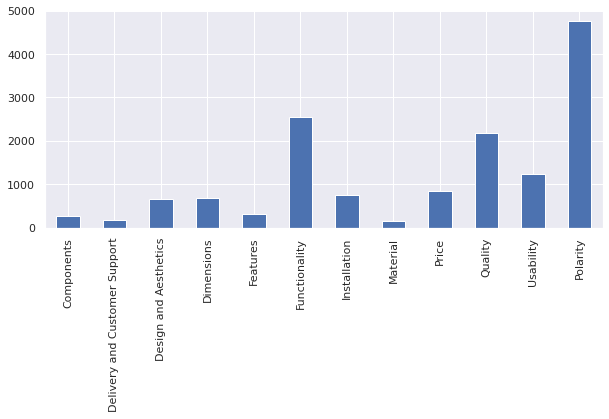

In [6]:
sns.set()
plt.figure(figsize=(10, 4))
train[aux_cols].sum(axis=0).plot.bar()
plt.show()

📌Most of the reviews are about functionality.

📌And second highest is the Quality of the product.

📌There are less number of reviews about the material.

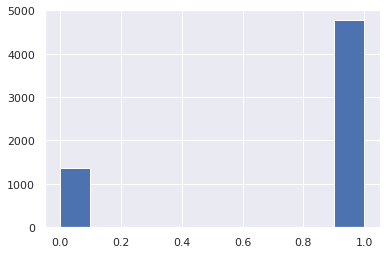

In [7]:
sns.set()
train.Polarity.hist()
plt.show()

📌The data set is imbalanced w.r.t Polarity. 

📌Most the reviews have positive sentiment.

In [8]:
train['Review'].apply(lambda x: len(x.split())).describe(percentiles=[0.5, 0.7, 0.8, 0.9, 0.99])

count    6136.000000
mean       30.008475
std        32.793149
min         2.000000
50%        19.000000
70%        32.000000
80%        44.000000
90%        68.000000
99%       159.950000
max       374.000000
Name: Review, dtype: float64

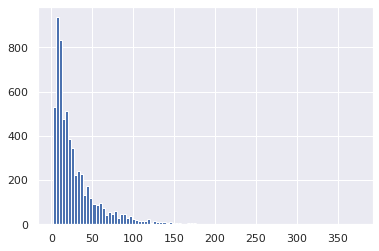

In [9]:
sns.set()
train['Review'].apply(lambda x: len(x.split())).hist(bins=100)
plt.show()

📌Most of the reviews have character length of 50.

📌The max character length is 372.

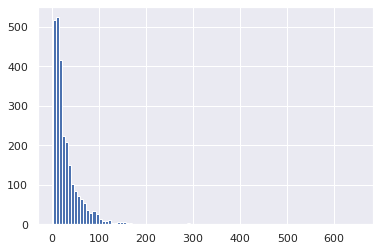

In [10]:
sns.set()
test['Review'].apply(lambda x: len(x.split())).hist(bins=100)
plt.show()

In [11]:
train['Review_len'] = train['Review'].apply(lambda x: len(x.split()))

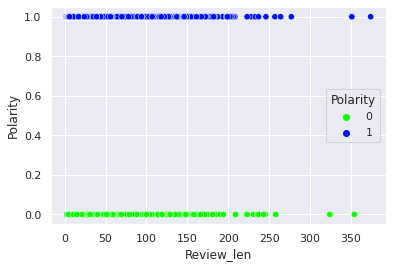

In [12]:
sns.scatterplot(data = train,  x="Review_len", y="Polarity", hue="Polarity", palette = "hsv", s=40, 
legend=True)
plt.show()

📌The review lengths are uniform irrespective of the polarity.

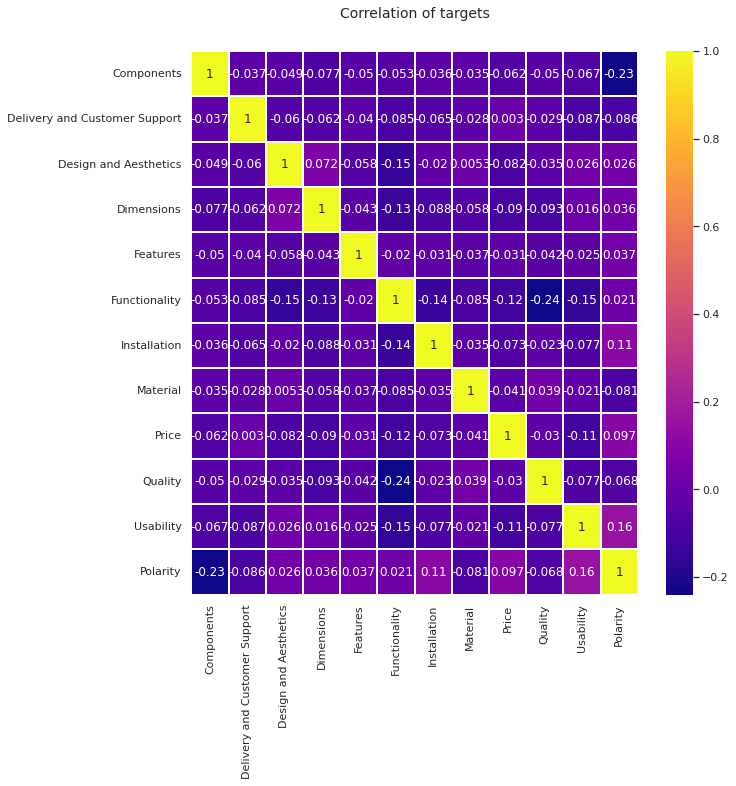

In [13]:
colormap = plt.cm.plasma
plt.figure(figsize=(10, 10))
plt.title('Correlation of targets',y=1.05,size=14)
sns.heatmap(train[aux_cols].corr(),linewidths=0.1,vmax=1.0,square=False,cmap=colormap,
           linecolor='white',annot=True)
plt.show()

📌Components and Polarity, Functionality and Quality are -ve'ly correlated.

📌Usabilty and Polarity have +ve correlation

In [14]:
texts = ' '.join([review for review in train.Review])

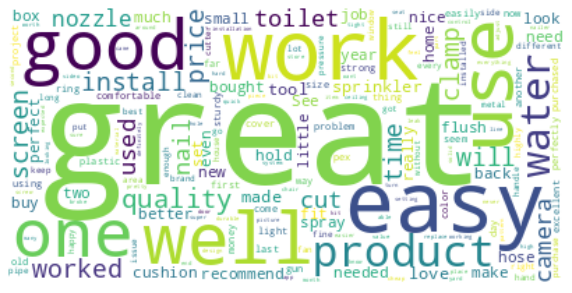

In [15]:
plt.figure(figsize=(10, 10))
word_cld = WordCloud(collocations=False, background_color='white').generate(texts)
plt.imshow(word_cld, interpolation='bilinear')
plt.axis('off')
plt.show()

📌Frequency plot of the words in all the reviews.


# Pre-Processing🛠

In [16]:
def lower_text(text):
    return text.lower()

def remove_punctuation(text):
    PUNCT_TO_REMOVE = string.punctuation
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def lemmatize(text):
    from nltk.corpus import wordnet
    from nltk.stem import WordNetLemmatizer

    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    pos_tagged_text = nltk.pos_tag(text.split())
    
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_html(text):
    from bs4 import BeautifulSoup
    
    return BeautifulSoup(text, "lxml").text

In [17]:
helpers = [remove_html, remove_urls, remove_emoji, lower_text, remove_punctuation, lemmatize]

In [18]:
for helper in helpers:
    train['Review'] = train['Review'].apply(helper)
    test['Review'] = test['Review'].apply(helper)

# Training ⚙

In [19]:
X = train['Review']

X_test = test['Review']

In [20]:
vect = TfidfVectorizer(max_features=5000,stop_words='english', ngram_range=(1, 2), lowercase=False)

In [21]:
X_tr = vect.fit_transform(X)

X_test_tr = vect.transform(X_test)

In [22]:
for col in aux_cols:
    print(f'\nProcessing...{col}')
    X_train, X_val, y_train, y_val = train_test_split(X_tr, train[col], 
                                                  test_size=0.2, 
                                                  random_state=42,
                                                 stratify = train[col])
    
    ratio = (len(train[col]) - sum(train[col])) / sum(train[col])
    
    w = compute_class_weight('balanced', np.unique(train[col]), train[col])
    weights = {
         np.unique(train[col])[0] : w[0], 
         np.unique(train[col])[1] : w[1]
    }
    
    xgb_model = XGBClassifier(objective='binary:logistic',random_state=42,eval_metric="logloss", 
                              max_depth=5, n_estimators=300, n_jobs=-1,reg_alpha=20, reg_lambda=50,
                              subsample=0.8,colsample_bytree = 0.7, scale_pos_weight = ratio,)
    xgb_model.fit(X_train, y_train)
    train_preds_xgb = xgb_model.predict_proba(X_train)[:, 1]
    print(f'Train log_loss: XGB -> {log_loss(y_train, train_preds_xgb)}')
    val_preds_xgb = xgb_model.predict_proba(X_val)[:, 1]
    print(f'Val log_loss: XGB -> {log_loss(y_val, val_preds_xgb)}')
    test_preds_xgb = xgb_model.predict_proba(X_test_tr)[:, 1]
    
    lr_model = LogisticRegression(C=30, solver='liblinear', class_weight=weights)
    lr_model.fit(X_train, y_train)
    train_preds_lr = lr_model.predict_proba(X_train)[:, 1]
    print(f'Train log_loss: LR -> {log_loss(y_train, train_preds_lr)}')
    val_preds_lr = lr_model.predict_proba(X_val)[:, 1]
    print(f'Val log_loss: LR -> {log_loss(y_val, val_preds_lr)}')
    test_preds_lr = lr_model.predict_proba(X_test_tr)[:, 1]
    
    rf_model = RandomForestClassifier(n_estimators=300, n_jobs=-1, max_depth=5, 
                                      random_state=42, class_weight=weights)
    rf_model.fit(X_train, y_train)
    train_preds_rf = rf_model.predict_proba(X_train)[:, 1]
    print(f'Train log_loss: RF -> {log_loss(y_train, train_preds_rf)}')
    val_preds_rf = rf_model.predict_proba(X_val)[:, 1]
    print(f'Val log_loss: RF -> {log_loss(y_val, val_preds_rf)}')
    test_preds_rf = rf_model.predict_proba(X_test_tr)[:, 1]
    
    lgbm_model = LGBMClassifier(n_estimators=500, n_jobs=-1, subsample=0.7, max_depth=6,
                                reg_alpha=20, reg_lambda=50, colsample_bytree=0.6, 
                                random_state=42, scale_pos_weight=ratio)
    lgbm_model.fit(X_train, y_train)
    train_preds_lgbm = lgbm_model.predict_proba(X_train)[:, 1]
    print(f'Train log_loss: LGBM -> {log_loss(y_train, train_preds_lgbm)}')
    val_preds_lgbm = lgbm_model.predict_proba(X_val)[:, 1]
    print(f'Val log_loss: LGBM -> {log_loss(y_val, val_preds_lgbm)}')
    test_preds_lgbm = lgbm_model.predict_proba(X_test_tr)[:, 1]
    
    ## Ensemble
    
    X_en_train = np.array([train_preds_xgb, train_preds_lr, train_preds_rf, train_preds_lgbm]).T
    X_en_val = np.array([val_preds_xgb, val_preds_lr, val_preds_rf, val_preds_lgbm]).T
    X_en_test = np.array([test_preds_xgb, test_preds_lr, test_preds_rf, test_preds_lgbm]).T
    
    model = LogisticRegression(C=5, class_weight=weights)
    model.fit(X_en_train, y_train)
    
    print(f'Ensemble Train log_loss: {log_loss(y_train, model.predict_proba(X_en_train)[:, 1])}')
    print(f'Ensemble Val log_loss: {log_loss(y_val, model.predict_proba(X_en_val)[:, 1])}')
    
    sample_sub[col] = model.predict_proba(X_en_test)[:, 1]


Processing...Components
Train log_loss: XGB -> 0.16101321857490192
Val log_loss: XGB -> 0.2467513489160582
Train log_loss: LR -> 0.026118564048040773
Val log_loss: LR -> 0.15349048425427242
Train log_loss: RF -> 0.6078180628857225
Val log_loss: RF -> 0.6156942186190201
Train log_loss: LGBM -> 0.25952030364428796
Val log_loss: LGBM -> 0.32220801406453714
Ensemble Train log_loss: 0.0033325366211284803
Ensemble Val log_loss: 0.23275239285618324

Processing...Delivery and Customer Support
Train log_loss: XGB -> 0.10093384130942848
Val log_loss: XGB -> 0.13392541067928254
Train log_loss: LR -> 0.012604511598897236
Val log_loss: LR -> 0.05655073976656196
Train log_loss: RF -> 0.5809282737394175
Val log_loss: RF -> 0.5847117219516688
Train log_loss: LGBM -> 0.1918446913333415
Val log_loss: LGBM -> 0.21713151171773826
Ensemble Train log_loss: 0.0020237107269647074
Ensemble Val log_loss: 0.07690413523647646

Processing...Design and Aesthetics
Train log_loss: XGB -> 0.1974339911285063
Val log_l

In [23]:
sample_sub

,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
0,0.989881,0.000782,0.000439,0.000187,0.000193,0.000590,0.000270,0.295555,0.000510,0.949807,0.000297,0.001476
1,0.000427,0.000417,0.000199,0.000210,0.000161,0.999361,0.000276,0.000166,0.000379,0.000294,0.000308,0.999841
2,0.000108,0.000144,0.000205,0.000216,0.000194,0.011610,0.000629,0.000141,0.000472,0.000774,0.998189,0.999732
3,0.000242,0.000297,0.000305,0.000203,0.000148,0.996842,0.000720,0.000174,0.000305,0.013191,0.000310,0.107372
4,0.000393,0.000257,0.000181,0.000434,0.000232,0.999492,0.000279,0.000223,0.000319,0.637644,0.000289,0.999811
...,...,...,...,...,...,...,...,...,...,...,...,...
2626,0.000183,0.000167,0.000378,0.000263,0.001082,0.001165,0.996793,0.000144,0.000316,0.013457,0.013222,0.999670
2627,0.001289,0.000315,0.000936,0.000214,0.000682,0.001993,0.000306,0.000180,0.003623,0.000497,0.000272,0.998032
2628,0.000113,0.000616,0.000213,0.000204,0.000125,0.995466,0.000264,0.000197,0.000290,0.997985,0.000230,0.999723
2629,0.000124,0.000200,0.997867,0.000925,0.000156,0.000983,0.000257,0.000585,0.001052,0.997950,0.000567,0.999705


In [24]:
sample_sub.to_csv('sample_sub_ensemble.csv', index=None)